# Transformer

Let's implement simple transformer using PyTorch!

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from tqdm import tqdm

import math
from importlib import reload

torch.manual_seed(5678)

If you have cuda available on your machine, then let's take advantage of it to help make the computation go faster.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Let's set some configurations for the neural network.

In [3]:
class Config():
    def __init__(self, context_size, batch_size,
        n_blocks=1, n_heads=2, embed_size=8, weight_tying=False):
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.embed_size = embed_size
        self.context_size = context_size
        self.batch_size = batch_size
        self.weight_tying = weight_tying


In [4]:
config = Config(
    context_size = 16,
    batch_size = 128,
    n_blocks = 1,
    n_heads = 2,
    embed_size = 8,
    weight_tying = False,
)

The preprocessing is somewhat involved. If you wish to see how this is done, you can examine `utils/preprocess.py` to see how this is done.

Transformers have a fixed context size, so if our sequences are too short, we must pad them. One reasonable choice is to pad the sequence on the left with our token for marking the start of a sequence `^`.

We also add a termination token `$` to mark the end of each sequence.

Because we are serious about machine learning, we always split our data at least into training and testing before we start training.

In [5]:
import utils.preprocess as pp
reload(pp)

dataset = pp.ShortSequenceDataset('data/restriction-sites.txt',
    context_size=config.context_size, batch_size=config.batch_size
).to(device)

config.vocab_size = len(dataset.vocab)
config.init_code = dataset.init_code

data_train, data_test = torch.utils.data.random_split(dataset, [0.9, 0.1])

(len(data_train), len(data_test))

(411, 45)

Let's examine the first three sample. Each sample consists of the encoded sequence, as well as the targets to be predicted.

In [6]:
data_train[0:3]

(tensor([[30, 30, 30, 30, 30, 30, 30, 19, 19,  4, 17, 19, 17, 19, 17, 17],
         [30, 30, 30, 30, 30, 30, 17, 26, 17, 15, 19,  1, 14,  4, 12,  2],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 19, 26, 23,  4, 23, 15, 17]],
        device='cuda:0'),
 tensor([[30, 30, 30, 30, 30, 30, 19, 19,  4, 17, 19, 17, 19, 17, 17,  0],
         [30, 30, 30, 30, 30, 17, 26, 17, 15, 19,  1, 14,  4, 12,  2,  0],
         [30, 30, 30, 30, 30, 30, 30, 30, 19, 26, 23,  4, 23, 15, 17,  0]],
        device='cuda:0'))

In this exercise, we are interested in next-token prediction, so the target which is just the encoded sequence right-shifted.
We can see this by decoding one of the sample sequence and the target.

In [7]:
print(dataset.decode(dataset[7][0]))
print(dataset.decode(dataset[7][1]))

^^^^^^^^^A/CCGGT
^^^^^^^^A/CCGGT$


Now, we are ready to start implementing our transformer!

Each transfomer block consists of an attention module, followed by a feedforward module.

The feedforward module is a **feedforward neural network** with one hidden layer and one output layer (which is also known as a **multilayer perceptron**.) The hidden layer in our network uses the **Gaussian Error Linear Unit** (GELU) transfer function. Other common transfer functions include the **Rectified Linear Unit** (RELU) and the **sigmoid function**.

The **multihead attention** module in the transformer architecture allows each token embedding to be contextualized by the embeddings of other tokens, using attention mechanism.

In [16]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attend = Attention(config)
        self.feed = Feedforward(config)

    def forward(self, X):
        X = X + self.attend(X)  # residual connection
        X = X + self.feed(X)    # residual connection
        return X

class Attention(nn.Module):
    """
    Masked multi-head attention.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        embed_size = config.embed_size
        context_size = config.context_size
        # key, query, value projections for all attention heads
        self.kqv = ???
        # output projection
        self.output = ???
        # mask out upper diagonal
        self.register_buffer("mask", torch.tril(torch.ones(context_size, context_size))
            .view(1, 1, context_size, context_size))

    def forward(self, X):
        # batch size, sequence length, and embedding dimensionality
        B, T, D = X.shape

        embed_size = self.config.embed_size
        n_heads = self.config.n_heads

        # (B, D, 3*D)  -> (B, D, D)
        # multiple each weight matrix with data and split
        query, key, value = self.kqv(X).split(embed_size, dim=2)
        # (B, D, D) -> (B, H, T, D/H)
        key = key.view(B, T, n_heads, D // n_heads).transpose(1, 2)  
        query = query.view(B, T, n_heads, D // n_heads).transpose(1, 2)  
        value = value.view(B, T, n_heads, D // n_heads).transpose(1, 2)  

        # (B, H, T, D/H) @ (B, H, D/H, T) -> (B, H, T, T)
        att = ???
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = ???

        # (B, H, T, T) @ (B, H, T, D/H) -> (B, H, T, D/H)
        Y = att @ ???

        # re-assemble outputs from all heads
        Y = Y.transpose(1, 2).contiguous().view(B, T, D)

        # linear map of all heads together
        Y = self.output(Y)
        return Y

class Feedforward(nn.Module):
    """
    Feedforward network.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        embed_size = config.embed_size
        self.hidden = nn.Linear(embed_size, 4*embed_size)
        self.gelu = nn.GELU()
        self.output = nn.Linear(4*embed_size, embed_size)
    
    def forward(self, X):
        X = self.hidden(X)
        X = self.gelu(X)
        X = self.output(X)
        return X


Now that the transformer block is implemented, we now implement GPT model.

In [9]:
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = ???
        self.pos_embed = ???
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_blocks)])
        if not config.weight_tying:
            self.unembed = nn.Linear(config.embed_size, config.vocab_size, bias=False)

    def forward(self, X, Y=None):
        # X is (B, T), Y is (B, T)
        pos = torch.arange(0, X.shape[1], dtype=torch.long).to(device)
        
        token_embeds = self.token_embed(X)  # (B, T, D)
        pos_embeds = self.pos_embed(pos)    # (B, T, D)
        embeds = token_embeds + pos_embeds

        for block in self.blocks:
            embeds = block(embeds)

        if config.weight_tying:
            # tie the unembedding weights to the embedding weights
            # linear function transposes the weight
            logits = fn.linear(embeds, self.token_embed.weight) # (B, T, C)
        else:
            logits = self.unembed(embeds)  # (B, T, C)

        if Y is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            Y = Y.view(B*T)
            loss = ???
        
        return logits, loss

    @torch.no_grad()
    def sample(self, size, n=1, X=None, temperature=1.0):
        """
        Generate n new sequences of specified size given context X.
        """
        if X is None:
            X = (torch.tensor([[config.init_code]])
                .repeat(n, 1).to(device))
        for _ in range(size):
            if X.size(1) > self.config.context_size:
                # sequence context is too long; crop it to context_size
                X_cropped = X[:, -self.config.context_size:]
            else:
                X_cropped = X
            # get prediction
            logits, _ = self(X_cropped)
            # get last time step and scale by temperature
            logits = logits[:, -1, :] / temperature
            probs = ???
            x_new = ???
            X = torch.cat((X, x_new), dim=1)   # (B, T+1)
        return X

Phew! That was a lot of code.

Now, it is time to take our GPT model for a test drive!

In [10]:
model = GPT(config).to(device)

Before training, our model has high loss, and it generates nonsensical sequence. We'll forgive our model, since it has not been trained on data yet.

In [11]:
X0, y0 = data_train[0:3]
logits, loss = model(X0, y0)

print(loss)
dataset.decode( model.sample(16, n=10), strip=True )

tensor(3.4116, device='cuda:0', grad_fn=<NllLossBackward0>)


['78A67NB-7TM407',
 'MNDG32CH3C_Y4KY',
 '-V64H/88392KG2)Y',
 '505S7YB-0)YS1K',
 'G531H7D20/S)S9(',
 'V7WRS_GH9-)9M26',
 '9-5C1D03(WWYWT6',
 'YDNC0R669-__91',
 '/4S1B0G_6NHD28__',
 '875V/693AW5/5B1']

Our data has been preprocessed. Our model has been implemented and instantiated. Now, all that is left to do is to train our model. Yippee!

In [17]:
import utils.train as tr
reload(tr)

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

model, losses_train, losses_test = tr.train(model, optim,
    data_train, data_test, config, n_epochs=50)

100%|██████████| 50/50 [00:00<00:00, 135.84it/s]


Now's the moment we've all been waiting for... how well does our trained model do?

In [14]:
print(f"loss: (train: {losses_train[-1]}, test: {losses_test[-1]})")
dataset.decode( model.sample(16, n=10), strip=True )

loss: (train: 0.8016835451126099, test: 0.8608261942863464)


['RYGA/NC',
 'C/CNTAG',
 'TCCNNGA',
 'GC/TCATA(_/21)',
 'ATCC/CNAG',
 'R/ATTTY',
 'CAYTG(8/7)',
 'AAT/NGG',
 'N/RGGT',
 'G/CCCTC']

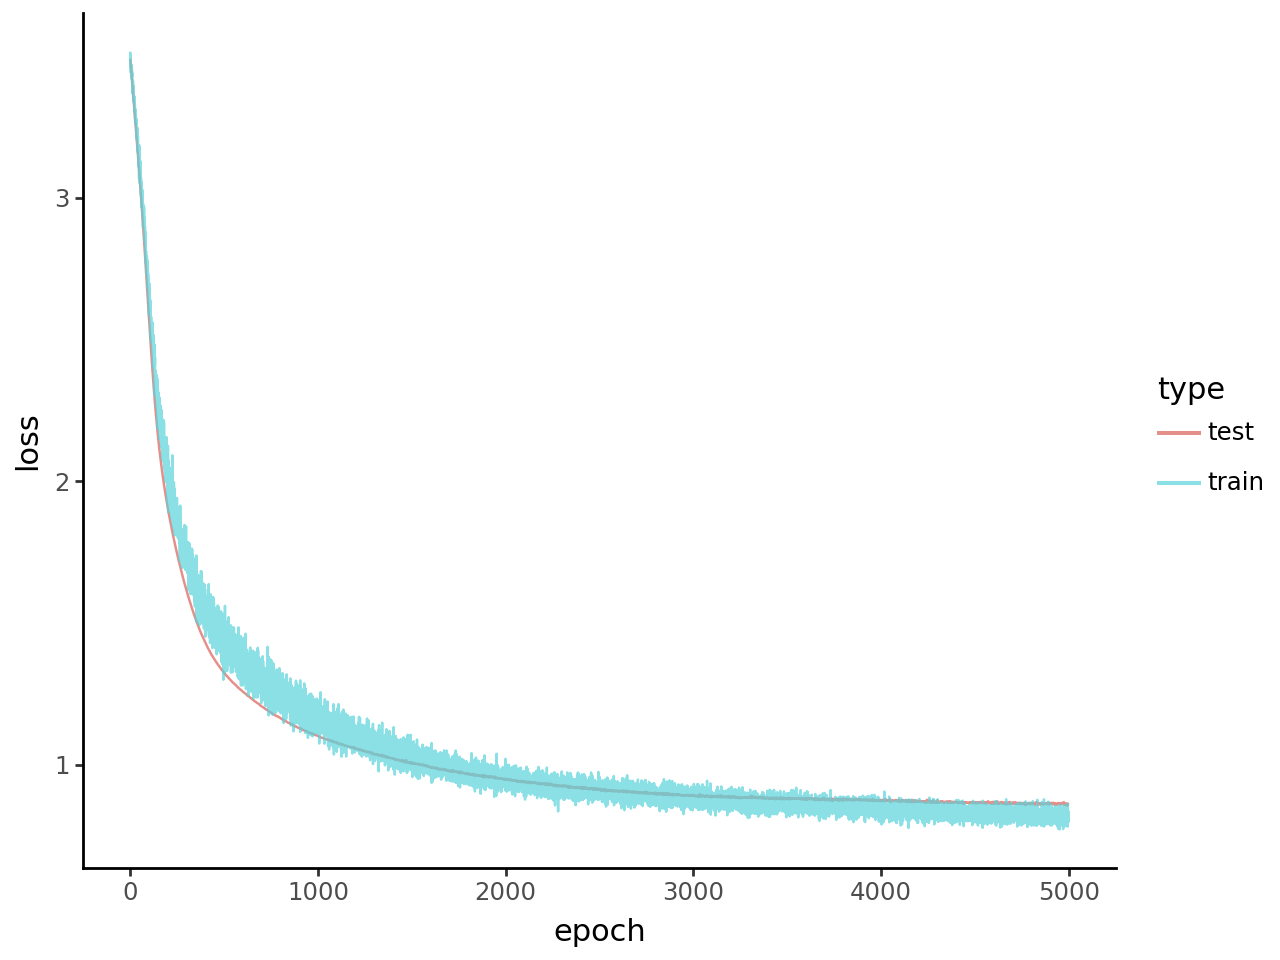

In [15]:
from utils.plot import plot_loss

plot_loss(losses_train, losses_test)

### Questions

1. How well does our model do after 50 epochs of training?
   How can we do better?

2. Play with the config values (hyperparameters).
   How can you improve the model performance?

3. What can you conclude from the training and test losses for a model
   with vs. without weight tying?
   (Hint: You will need to run at least 1000 epochs.)

### Bonus questions

1. Compared against the [transformer paper][1], our transformer is missing
   a few things. Implement the layer normalization and see how the model
   performs.
   (Hint: It is now known that implementing layer normalization
   **before** each of the attention and feedforward modules
   rather than after could produce more performant models.)

2. The transformer paper also uses drop-out layers. Add them to the model.


[1]: https://arxiv.org/abs/1706.03762